In [8]:
from scipy.io import loadmat
from scipy.sparse import issparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from Data import VFLDataset
from torch.utils.data import DataLoader
import VFL
import torch
import os
DIR = "Data"

In [9]:
file_name = 'PCMAC.mat'
mat = loadmat(os.path.join(DIR, file_name))
X = mat["X"]
y = mat["Y"]
if issparse(X):
    X = X.todense()
y = y.flatten()
print(file_name, X.shape, y.shape)
y = y - 1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
dataset = VFLDataset(data_source=(X, y), 
                    num_clients=2,
                    gini_portion=None,
                    insert_noise=False,
                    test_size=0.5)
train_loader = DataLoader(dataset.train(), batch_size=128, shuffle=True)
val_loader = DataLoader(dataset.valid(), batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset.test(), batch_size=1000, shuffle=True)
input_dim_list = dataset.get_input_dim_list()
output_dim = np.unique(y).size
criterion = torch.nn.CrossEntropyLoss()

PCMAC.mat (1943, 3289) (1943,)
Client 0: Feature Index 0-1096
Client 1: Feature Index 1097-2192
Server : Feature Index 2193-3288


In [10]:
models, top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2)

gini_labels = dataset.gini_filter(0.5)
feat_idx_list = dataset.get_feature_index_list()
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
gini_models, gini_top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='STG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2, mus=mus)
    
mus = VFL.initialize_mu(gini_labels, feat_idx_list)
dual_models, dual_top_model = VFL.make_binary_models(
                            input_dim_list=input_dim_list,
                            type='DualSTG',
                            emb_dim=8,
                            output_dim=output_dim, hidden_dims=[8, 8],
                            activation='relu', lam=0.2, mus=mus, top_lam=0.1)

In [11]:
results = []
for i, step in enumerate([10]*20):
    history = VFL.train(models, top_model, train_loader, val_loader, test_loader,
                epochs=step, noise_label=None, criterion=criterion, 
                verbose=False, save_mask_at=100000)
    
    num_feats = history.tail(1)['num_feats'].item()
    acc = history.tail(1)['test_acc'].item()
    print(f'STG:{num_feats}')
    print(f'STG Acc:{acc}')
    gini_history = VFL.train(
        gini_models, gini_top_model, train_loader, val_loader, test_loader,
        epochs=step, noise_label=None, criterion=criterion,
        verbose=False, save_mask_at=100000)
    gini_num_feats = gini_history.tail(1)['num_feats'].item()
    gini_acc = gini_history.tail(1)['test_acc'].item()
    print(f'GINI+STG: {gini_num_feats}')
    print(f'GINI+STG Acc: {gini_acc}')
    dual_history = VFL.train(
        dual_models, dual_top_model, train_loader, val_loader, test_loader,
        epochs=step, noise_label=None, criterion=criterion,
        verbose=False, save_mask_at=100000, freeze_top_till=5)
    saved_communication = dual_history['num_emb'].sum()
    pred_emb = dual_history.tail(1)['num_emb'].item()
    dual_acc = dual_history.tail(1)['test_acc'].item()
    dual_num_feats = dual_history.tail(1)['num_feats'].item()
    print(f'DualSTG: {dual_acc}')
    print(f'DualSTG: {saved_communication}')
    print(f'DualSTG: {dual_num_feats}')
    print("What's the Test accuracy if SFFS only have this much features?")
    percentage = num_feats/X.shape[1]
    sffs_labels = dataset.gini_filter(percentage)
    sffs_labels = sffs_labels.flatten()
    X_temp, y_temp = dataset.get_data()
    X_filtered = X_temp[:, np.nonzero(sffs_labels)].squeeze() 
    print(X_filtered.shape)
    sffs_dataset = VFLDataset(data_source=(X_filtered, y), 
                    num_clients=2,
                    gini_portion=None,
                    insert_noise=False,
                    test_size=0.5)
    sffs_train_loader = DataLoader(sffs_dataset.train(), batch_size=128, shuffle=True)
    sffs_val_loader = DataLoader(sffs_dataset.valid(), batch_size=1000, shuffle=True)
    sffs_test_loader = DataLoader(sffs_dataset.test(), batch_size=1000, shuffle=True)
    sffs_input_dim_list = sffs_dataset.get_input_dim_list()
    sffs_output_dim = np.unique(y).size
    sffs_models, sffs_top_model = VFL.make_binary_models(
                            input_dim_list=sffs_input_dim_list,
                            type='FNN',
                            emb_dim=8,
                            output_dim=sffs_output_dim, hidden_dims=[8, 8],
                            activation='relu')
    sffs_history = VFL.train(sffs_models, sffs_top_model, sffs_train_loader, 
                                sffs_val_loader, sffs_test_loader,
                                epochs=step, noise_label=None, criterion=criterion,
                                verbose=False, save_mask_at=100000)
    sffs_acc = sffs_history.tail(1)['test_acc'].item()
    print(f'SFFS Acc: {sffs_acc}')
    results.append([acc, num_feats, gini_acc, gini_num_feats, dual_num_feats,
        dual_acc, saved_communication, pred_emb, sffs_acc])


STG:2119
STG Acc:0.9681069958847737
GINI+STG: 1692
GINI+STG Acc: 0.9722222222222222
DualSTG: 0.9372427983539094
DualSTG: 240
DualSTG: 1698
What's the Test accuracy if SFFS only have this much features?
(1943, 2119)
Client 0: Feature Index 0-706
Client 1: Feature Index 707-1412
Server : Feature Index 1413-2118
SFFS Acc: 0.9979423868312757
STG:1110
STG Acc:0.9753086419753086
GINI+STG: 1045
GINI+STG Acc: 0.9722222222222222
DualSTG: 0.9794238683127572
DualSTG: 239
DualSTG: 1164
What's the Test accuracy if SFFS only have this much features?
(1943, 1110)
Client 0: Feature Index 0-369
Client 1: Feature Index 370-739
Server : Feature Index 740-1109
SFFS Acc: 0.9989711934156379
STG:697
STG Acc:0.9825102880658436
GINI+STG: 763
GINI+STG Acc: 0.9763374485596708
DualSTG: 0.98559670781893
DualSTG: 228
DualSTG: 849
What's the Test accuracy if SFFS only have this much features?
(1943, 697)
Client 0: Feature Index 0-232
Client 1: Feature Index 233-464
Server : Feature Index 465-696
SFFS Acc: 0.99176954

In [13]:
import pandas as pd
results = pd.DataFrame(results, columns=['STG_acc', 'STG_feats', 
'GINI_acc', 'GINI+STG_feats', 
'DualSTG_feats', 'DualSTG_acc', 'Saved_communication', 'pred_emb',
'SFFS_acc'])
results['Epochs'] = np.arange(0, 200, 10)
results['STG_communication'] = 240
results.to_csv('results/CSVResults/pcmac_results.csv')

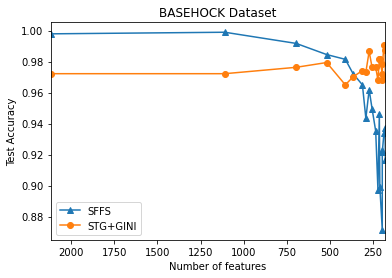

In [14]:
import matplotlib.pyplot as plt
x = results['STG_feats']
#plt.plot(results['STG_feats'], results['STG_acc'], label='STG', )
plt.plot(results['STG_feats'], results['SFFS_acc'], label='SFFS', marker='^')
# plt.plot(results['STG_feats'], results['DualSTG_acc'], label='DualSTG')
plt.plot(results['STG_feats'], results['GINI_acc'], label='STG+GINI', marker='o')
plt.xlim(max(x), min(x))
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Test Accuracy')
plt.title('BASEHOCK Dataset')
plt.show()

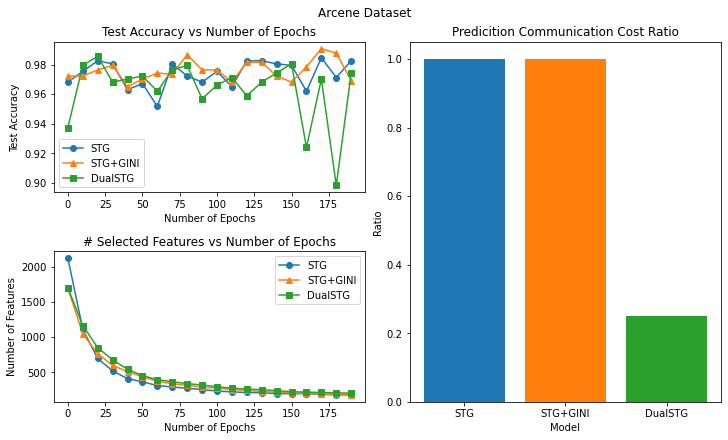

In [15]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              figsize=(10, 6), constrained_layout=True)
axd['upper left'].plot(np.arange(0, 200, 10), results['STG_acc'], label='STG', marker='o')
axd['upper left'].plot(np.arange(0, 200, 10), results['GINI_acc'], label='STG+GINI', marker='^')
axd['upper left'].plot(np.arange(0, 200, 10), results['DualSTG_acc'], label='DualSTG', marker='s')
axd['upper left'].legend()
axd['upper left'].set_xlabel('Number of Epochs')
axd['upper left'].set_ylabel('Test Accuracy')
axd['upper left'].set_title('Test Accuracy vs Number of Epochs')

axd['lower left'].plot(np.arange(0, 200, 10), results['STG_feats'], label='STG', marker='o')
axd['lower left'].plot(np.arange(0, 200, 10), results['GINI+STG_feats'], label='STG+GINI', marker='^')
axd['lower left'].plot(np.arange(0, 200, 10), results['DualSTG_feats'], label='DualSTG', marker='s')
axd['lower left'].set_xlabel('Number of Epochs')
axd['lower left'].set_ylabel('Number of Features')
axd['lower left'].set_title('# Selected Features vs Number of Epochs')
axd['lower left'].legend()


group_names = ['STG', 'STG+GINI', 'DualSTG']
values = [1, 1, results.tail(1)['pred_emb'].item()/24]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axd['right'].bar(group_names, values, align='center', color=colors)
axd['right'].set_xlabel('Model')
axd['right'].set_ylabel('Ratio')
axd['right'].set_title('Predicition Communication Cost Ratio')
fig.suptitle('Arcene Dataset')
plt.show()